<a href="https://colab.research.google.com/github/YB0223/Project3/blob/main/Section2_%EB%B6%80%EB%8F%99%EC%82%B0%EB%A7%A4%EB%A7%A4_%EB%B6%84%EC%84%9D_%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#국내 부동산매매 분석-분석

##PIP 설치

In [1]:
!pip install xmltodict
!pip install PublicDataReader
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##데이터 추출 및 전처리

###공공데이터 포털 자료 조회
참고 블로그: 
1. https://wooiljeong.github.io/python/public_data_reader_01/
2. https://ai-creator.tistory.com/24

In [ ]:
import PublicDataReader as pdr
print(pdr.__version__)
print(pdr.__info__)

2021.11.17
- Author : Wooil Jeong
- E-mail : wooil@kakao.com
- Github : https://github.com/WooilJeong/PublicDataReader
- Blog : https://wooiljeong.github.io


In [ ]:
serviceKey="dgU%2BczPYvT1vvJTX1UJruxB8G3rIM5ge8LgeZxFXapS%2BDi4k9ojiyKNhbS9AlcgtHiqA7Mxj4ut3nVii%2FZPkoQ%3D%3D"

In [ ]:
#지역코드 리스트
code=pdr.code_list()

#DB 시스템
ts=pdr.Transaction(serviceKey,debug=True)

ConnectionError: ignored

###함수정의

####각 시도명 내에 있는 지역코드 조회
```python
def locCode(result,search_name)
```



In [ ]:
def locCode(result,search_name):
  location=result.copy().loc[(result.copy()['시도명'].str.contains(search_name, na =False))].iloc[:,1:4]
  return location.copy()[~location.duplicated()].reset_index(drop=True)

####유형별 월간 시군구 내에 있는 매매데이터 조회
```python
def search_data_month_Gu_for_prod(ts,prod,locCode,yearMonth)
```


In [ ]:
def search_data_month_Gu_for_prod(ts,prod,locCode,yearMonth):  
  trans='매매'
  '''
    **지역코드는 준비된걸 입력
    
    공통필터:     년, 월, 일, 거래금액, 전용(건물,거래)면적, 
    
    아파트,다세:  공통필터,건축년도,층,                 유형, 전용면적
    단독,다가구:  공통필터,건축년도,층,                 유형, 대지면적, 연면적
    분양입주권:   공통필터,        ,층,                 유형, 전용면적

    토지:         공통필터,        ,용도지역,지목,      유형, 거래면적
    상업업무용:   공통필터,건축년도,용도지역,건축주용도,유형, 건물면적
  '''
  ##filter정의==============================================================================================
  #거주위주: 주택유형으로 구분, 층 추가---------------------------------------------------------------
  if prod=="아파트":
    filter=['지역코드','전용면적','년','월','일','거래금액','건축년도','층']                     #아파트 유형추가 
  elif prod=="오피스텔":
    filter=['지역코드','전용면적','년','월','일','거래금액','건축년도','층']                     #오피 유형추가
  elif prod=="연립다세대":
    filter=['지역코드','전용면적','년','월','일','거래금액','건축년도','층']                     #연립다세대
  
  elif prod=="단독다가구":
    filter=['지역코드','대지면적','연면적','년','월','일','거래금액','건축년도','주택유형']      #단독다가구 주택유형 필터명 변경 층추가
  
  #번외-----------------------------------------------------------------------------------------------
  elif prod=="분양입주권":
    filter=['지역코드','전용면적','년','월','일','거래금액',            '층']                    #분양입주권
  
  elif prod=="토지":
    filter=['지역코드','거래면적','년','월','일','거래금액',            '용도지역','지목']       #토지
  
  #토지와 성격비슷
  elif prod=="상업업무용":
    filter=['지역코드','건물면적','년','월','일','거래금액','건축년도','용도지역','건물주용도']  #상업업무용


  ##결과출력================================================================================================
  i=0
  while(1):
    
    result=ts.read_data(prod, trans, locCode, yearMonth)
    if result is None:
      i+=1
      print(f"prod:{prod},yearMonth:{yearMonth},locCode:{locCode} 재시작--{i}회")
      if i%5==0:
        ts=pdr.Transaction(serviceKey,debug=True)
      continue
    else:
      i=0
      break
  result=result.copy()[filter]
  if prod !='단독다가구':
    result['유형']=prod
  else:
    BtC=0.7   #건폐율 70% 기준
    floor_1=result.copy()['대지면적']
    floor_1=floor_1.copy().apply(lambda x: float(x)*BtC)
    float_floor=1+result.copy()['연면적'].apply(lambda x: float(x))//floor_1
    result['층']=float_floor.copy().apply(lambda x: str(int(x)))
    result.rename(columns={"주택유형":"유형"}, inplace = True)
    filter=['지역코드','연면적','년','월','일','거래금액','건축년도','층','유형']  
    result=result.copy()[filter]
  ##Return==================================================================================================
  name=result.copy().columns[result.copy().columns.str.contains('면적')][0]
  result.rename(columns={"지역코드":"시군구코드",name:"면적"},inplace=True)
  result['시군구코드']=result.copy()['시군구코드'].apply(lambda x: int(x))
  return result

####[고찰]
#####월간결과>>유형별통합>>입력된 도시의 구들 통합>>입력된 도시의 연간>>몇년간
유형별통합:
>이부분을 다르게 선택해주고싶다.
>공통4묶음, 단타4묶음

입력된 도시구들 통합
>Seoul입력변수를 받구싶다.
>concat의 연장

####위 데이터를 유형별 통합
```python
def search_data_month_Gu(ts,locCode,yearMonth)
  ```

In [ ]:
import pandas as pd
from google.colab import output
def search_data_month_Gu(ts,locCode,yearMonth): 
  prods=['아파트','오피스텔','단독다가구','연립다세대']
  con_data=[]
  for prod in prods:
    con_data.append(search_data_month_Gu_for_prod(ts,prod,locCode,yearMonth))
  result=pd.concat(con_data.copy()).reset_index(drop=True)
  return result

####도시별 통합


```python
def search_data_month(ts,city,yearMonth)
```



In [ ]:
def search_data_month(ts,city,yearMonth):
  con_data=[]
  filter=['년','월','일','시도명','시군구명','유형','면적','층','건축년도','거래금액']
  for gu in city['시군구코드'][1:]:
    data_Gu=search_data_month_Gu(ts,gu,yearMonth)
    data_Gu=pd.merge(data_Gu.copy(),city.copy(), on='시군구코드', how='left')
    data_Gu=data_Gu.copy().drop('시군구코드',axis=1)
    data_Gu=data_Gu.copy()[filter]
    con_data.append(data_Gu)
  result=pd.concat(con_data.copy()).reset_index(drop=True).copy()
  return result

####시간카운트


```python
def count_time(s_time)
```



In [ ]:
import time
def count_time(s_time):
  if s_time is None:
    return -1
  t=round(time.time()-s_time,2)
  if t>=3600*24:
    d=t//(3600*24)
    h=(t%(3600*24))//3600
    m=((t%(3600*24))%3600)//60
    s=((t%(3600*24))%3600)%60
    print(f"{int(d)}일 {str(int(h)).zfill(2)}시 {str(int(m)).zfill(2)}분 {round(s)}초 경과")
  elif t>=3600:
    h=t//3600
    m=(t%3600)//60
    s=(t%3600)%60
    print(f"{str(int(h)).zfill(2)}시 {str(int(m)).zfill(2)}분 {round(s)}초 경과")
  elif t>=60:
    m=t//60
    s=t%60
    print(f"{str(int(m)).zfill(2)}분 {round(s)}초 경과")
  else:
    print(f"{t}초 경과")

####특정 1년간 시도별 내에 있는 매매데이터 조회 


```python
def search_data_year(ts,city,year,s_time)
```



In [ ]:
def search_data_year(ts,city,year,s_time=None):
  con_data=[]
  year=str(year)
  for i in range(12):
    month=str(i+1)
    month=month.zfill(2)
    yearMonth=year+month
    con_data.append(search_data_month(ts,city,yearMonth))
    print(yearMonth+" 완료")
    count_time(s_time)
  result=pd.concat(con_data.copy()).reset_index(drop=True)
  return result

####시작년도에서 n년간 자료모음


```python
def search_data(ts,city,year,n)
```



In [ ]:
def search_data(ts,city,year,n):
  con_data=[]
  year=int(year)
  cityname=city.copy()['시도명'].copy()[0]
  vnames = [i for i in globals() if globals()[i] is city]
  for i in range(n):
    search_year=year-i
    #진행시작
    s_time=time.time()
    print(f"{i+1}/{n}진행 중......")
    count_time(s_time)
    year_data=search_data_year(ts,city,search_year,s_time)
    con_data.append(year_data.copy())
    print(f"{i+1}/{n}진행 완료!")
    count_time(s_time)
    #csv저장
    file_name=f"{cityname}의 {year}부터{n}년간의데이터_{search_year}년.csv"
    year_data.copy().to_csv(file_name, mode='a', header=False)  
    print(file_name+" 저장완료")
    count_time(s_time)
  result=pd.concat(con_data.copy()).reset_index(drop=True)
  output.clear()
  print(f"{n}년치 데이터 조회 완료")
  count_time(s_time)
  #csv저장
  file_name=f"{cityname}의 {year}부터{n}년간의데이터_총합본.csv"
  result.copy().to_csv(file_name, mode='a', header=False)
  print(file_name+" 저장완료")
  count_time(s_time)
  return result

###지역별 코드 저장
>>
'서울특별시', '부산직할시', '대구직할시', '인천직할시', '광주직할시', '대전직할시', '부산광역시',
'대구광역시', '인천광역시', '광주광역시', '대전광역시', '울산광역시', '세종특별자치시', '경기도',
'북부출장소', '강원도', '동해출장소', '충청북도', '충청남도', '전라북도', '전라남도', '경상북도',
'경상남도', '제주도', '제주특별자치도'


In [ ]:
#결과저장
Seoul=locCode(code,"서울")
Kyounggi=locCode(code,"경기도")
Incheon=locCode(code,"인천")
Jeju=locCode(code,"제주")

In [ ]:
#출력예시
Seoul.head()

In [ ]:
def print_YpD(strings,x):
  N_len=len(x)
  N=N_len*12
  result=round(1000/N,3)
  tf_ect=1000-int(N*round(result))
  print(strings,N_len,"개 ",result,"년/일"," 남은 트래픽:",tf_ect,"회 조회가능 개월수: ",round(tf_ect/N_len,2))
print_YpD("서울시: ",Seoul)
print_YpD("경기도: ",Kyounggi)
print_YpD("인천시: ",Incheon)
print_YpD("제주도: ",Jeju)

### 데이터 저장
####조회시 주의사항
>[일일 트래픽 제한 1000건]
>>통합인경우
>>
>>48 * 시군구수 * N수씩 조회
>>
>>(1* 4 * 시군구수 * 12 * N건)+eroor수씩 조회 
>
>>따로인경우
>>
>>12 * 시군구수 * N수씩 조회
>>
>>(1 * 시군구수 * 12 * N건)+eroor수씩 조회 

In [ ]:
#data=search_data(ts,Seoul,2021,3)
#display(data.head())
#data.shape

## 데이터 분석

###한글시각화

In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent 

In [3]:
#font 체크
import matplotlib.font_manager as fm
font_list = [font.name for font in fm.fontManager.ttflist]
font_list

['DejaVu Sans Mono',
 'STIXSizeFourSym',
 'STIXNonUnicode',
 'cmmi10',
 'DejaVu Sans Display',
 'cmsy10',
 'STIXGeneral',
 'STIXSizeFiveSym',
 'STIXSizeOneSym',
 'DejaVu Serif',
 'cmex10',
 'cmss10',
 'STIXNonUnicode',
 'STIXGeneral',
 'STIXGeneral',
 'STIXSizeTwoSym',
 'DejaVu Sans',
 'DejaVu Sans Mono',
 'DejaVu Sans',
 'STIXNonUnicode',
 'DejaVu Sans',
 'DejaVu Sans Mono',
 'DejaVu Serif',
 'STIXNonUnicode',
 'STIXSizeThreeSym',
 'STIXSizeTwoSym',
 'STIXSizeOneSym',
 'cmtt10',
 'cmb10',
 'STIXSizeThreeSym',
 'DejaVu Serif Display',
 'DejaVu Serif',
 'DejaVu Sans Mono',
 'STIXGeneral',
 'DejaVu Sans',
 'cmr10',
 'DejaVu Serif',
 'STIXSizeFourSym',
 'Liberation Sans',
 'Liberation Sans Narrow',
 'Liberation Serif',
 'NanumMyeongjo',
 'Liberation Serif',
 'Liberation Sans',
 'Liberation Serif',
 'NanumSquareRound',
 'Liberation Sans Narrow',
 'NanumSquare',
 'NanumGothic',
 'Liberation Sans Narrow',
 'Liberation Sans Narrow',
 'Liberation Mono',
 'Liberation Sans',
 'NanumBarunGothic',

###데이터 불러오기

In [4]:
#from google.colab import files
#myfile= files.upload()
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
def load_data(path,name_parameter=''):
  result=[]  
  for i in os.listdir(data_path):
    if '.' in i:
      result.append(pd.read_csv(data_path+i,names=name_parameter))
  return pd.concat(result).reset_index(drop=True)

In [6]:
import os
import pandas as pd
data_path='/content/drive/MyDrive/부동산매매분석/'
name_parameter=['년','월','일','시도명','시군구명','유형','면적','층','건축년도','거래금액']
df=load_data(data_path,name_parameter)
df.shape

(1518925, 10)

###이상치,nan,공백값 제거

NaN값: 건축년도에 존재, 약 152만건 중 3112개 존재

실제자료와 비교시 기입이 안된상태이며 특별한 규칙도 없기에 삭제해도 용이함.

####특성분석을 위한 코드

In [7]:
problem1=df[df['건축년도'].isna()].copy()
problem1.head()

,년,월,일,시도명,시군구명,유형,면적,층,건축년도,거래금액
517,2021,1,5,서울특별시,용산구,오피스텔,47.65,6,NaN,"72,000"
519,2021,1,7,서울특별시,용산구,오피스텔,48.57,8,NaN,"70,000"
528,2021,1,15,서울특별시,용산구,오피스텔,47.65,12,NaN,"71,500"
529,2021,1,16,서울특별시,용산구,오피스텔,42.50,11,NaN,"71,000"
531,2021,1,19,서울특별시,용산구,오피스텔,55.99,15,NaN,"71,500"


In [8]:
problem1.shape

(3112, 10)

In [9]:
problem1_0=problem1[problem1.columns[:6]]
problem1_0['필터']=problem1_0.copy()['년'].apply(lambda x: str(x))+'년 '+problem1_0.copy()['월'].apply(lambda x: str(x))+'월 '+problem1_0.copy()['시군구명']+' '+problem1_0.copy()['유형']
problem1_0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,년,월,일,시도명,시군구명,유형,필터
517,2021,1,5,서울특별시,용산구,오피스텔,2021년 1월 용산구 오피스텔
519,2021,1,7,서울특별시,용산구,오피스텔,2021년 1월 용산구 오피스텔
528,2021,1,15,서울특별시,용산구,오피스텔,2021년 1월 용산구 오피스텔
529,2021,1,16,서울특별시,용산구,오피스텔,2021년 1월 용산구 오피스텔
531,2021,1,19,서울특별시,용산구,오피스텔,2021년 1월 용산구 오피스텔
...,...,...,...,...,...,...,...
1512472,2012,12,6,서울특별시,종로구,단독,2012년 12월 종로구 단독
1512593,2012,12,3,서울특별시,중구,단독,2012년 12월 중구 단독
1512602,2012,12,24,서울특별시,중구,단독,2012년 12월 중구 단독
1512879,2012,12,3,서울특별시,성동구,단독,2012년 12월 성동구 단독


In [10]:
#search_data_month_Gu_for_prod(ts,'오피스텔',Seoul[Seoul['시군구명']=='용산구']['시군구코드'].values[0],'202101')

In [11]:
x=problem1_0['필터'].unique()
print(len(x))
print(x)

1014
['2021년 1월 용산구 오피스텔' '2021년 1월 광진구 다가구' '2021년 1월 동대문구 오피스텔' ...
 '2012년 12월 중구 단독' '2012년 12월 성동구 단독' '2012년 12월 강북구 단독']


####위 결론에 따른 이상치 제거

In [12]:
df_alt1=df[~df['건축년도'].isna()].reset_index(drop=True).copy()
df_alt1.isna().sum().sum(),df_alt1.isnull().sum().sum(),df.shape

(0, 0, (1518925, 10))

In [13]:
df_alt1['거래금액']=df_alt1.거래금액.str.replace(',','').astype(int)
df_alt1.head()

,년,월,일,시도명,시군구명,유형,면적,층,건축년도,거래금액
0,2021,1,14,서울특별시,종로구,아파트,129.76,2,2000.0,130000
1,2021,1,7,서울특별시,종로구,아파트,144.52,6,2008.0,150000
2,2021,1,15,서울특별시,종로구,아파트,174.55,4,2004.0,175000
3,2021,1,15,서울특별시,종로구,아파트,174.55,4,2004.0,175000
4,2021,1,17,서울특별시,종로구,아파트,123.13,13,2004.0,180000


In [14]:
df_alt1['거래금액'].describe().astype(int)

count    1515813
mean       49623
std        50380
min          350
25%        22000
50%        35250
75%        59800
max      3000000
Name: 거래금액, dtype: int64

#####실제데이터비교

In [15]:
#real_data=ts.read_data('단독다가구','매매',Seoul[Seoul['시군구명']=='종로구']['시군구코드'].values[0],'202006')

In [16]:
#real_data.loc[37]

###1차시각화

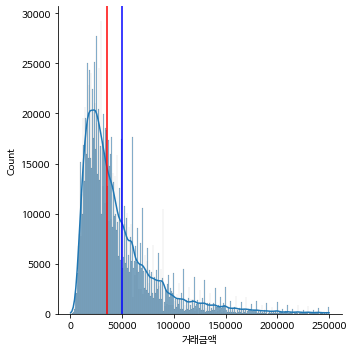

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='NanumBarunGothic') 
## SalePrice의 확률밀도함수를 그려보겠습니다
df_alt1_graph=df_alt1[df_alt1['거래금액']<=250000]
sns.displot(df_alt1_graph['거래금액'], kde=True)

## 평균과, 중간값으로 수직선을 그려보겠습니다.
plt.axvline(df_alt1['거래금액'].mean(), color='blue')
plt.axvline(df_alt1['거래금액'].median(), color='red');

위 분포 left skew이니 log값 적용

In [18]:
import numpy as np
df_alt1_exp=df_alt1.copy()
df_alt1_exp['log']=np.log(df_alt1_exp['거래금액'])
df_alt1_exp['log']
df_alt1_exp=df_alt1_exp.drop('거래금액',axis=1)


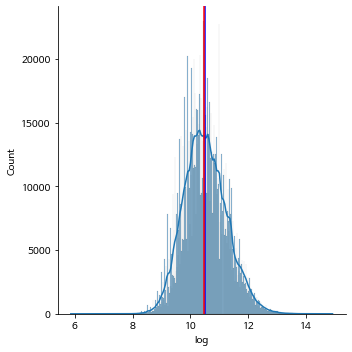

In [19]:
plt.rc('font', family='NanumBarunGothic') 
## SalePrice의 확률밀도함수를 그려보겠습니다
sns.displot(df_alt1_exp['log'], kde=True)

## 평균과, 중간값으로 수직선을 그려보겠습니다.
plt.axvline(df_alt1_exp['log'].mean(), color='blue')
plt.axvline(df_alt1_exp['log'].median(), color='red');

In [20]:
df_alt2=df_alt1.copy()
df_alt2['금액/면적']=(df_alt1['거래금액']/df_alt1['면적']).apply(lambda x: round(x,2))
df_alt2['log']=np.log(df_alt2['금액/면적'])
df_alt2['년월']=(df_alt1.copy()['년'].apply(lambda x: str(x))+df_alt1.copy()['월'].apply(lambda x: str(x).zfill(2)))

In [21]:
alt2_describe0=df_alt2.groupby(["년월",'유형'])['거래금액'].describe().apply(lambda x: round(x,-2))
alt2_describe1=df_alt2.groupby(["년월",'유형'])['금액/면적'].describe().apply(lambda x: round(x,2))
display(alt2_describe0)
alt2_describe1

count      mean       std      min      25%       50%  \
년월     유형                                                              
201201 다가구     100.0   67000.0   59900.0   6000.0  37500.0   49800.0   
       단독      200.0   49300.0   30000.0   4000.0  30000.0   43000.0   
       아파트    2800.0   42800.0   27400.0   4500.0  26400.0   36000.0   
       연립다세대  1700.0   19800.0   10600.0   3700.0  14000.0   18500.0   
       오피스텔    600.0   18500.0   14200.0   3400.0  12000.0   15500.0   
...              ...       ...       ...      ...      ...       ...   
202112 다가구     100.0  173300.0  212500.0  27000.0  82000.0  124200.0   
       단독      300.0  189000.0  276800.0  10000.0  75000.0  125700.0   
       아파트    1100.0  106300.0   97600.0   8500.0  48000.0   85500.0   
       연립다세대  3500.0   31700.0   23900.0   4000.0  19900.0   28000.0   
       오피스텔   1800.0   24600.0   15800.0   5000.0  16600.0   23000.0   

                   75%        max  
년월     유형                          
201201 다가구     78000.0   413800.0  
       단독      59900.0   165000.0  
       아파트     51500.0   417900.0  
       연립다세대   23000.0   180000.0  
       오피스텔    22600.0   270000.0  
...                ...        ...  
202112 다가구    185000.0  2000000.0  
       단독     211200.0  3000000.0  
       아파트    130000.0  1200000.0  
       연립다세대   37200.0   470000.0  
       오피스텔    29200.0   304000.0  

[600 rows x 8 columns]

count     mean      std     min     25%      50%      75%  \
년월     유형                                                                  
201201 다가구     115.0   289.87   151.26  127.08  210.53   256.80   309.26   
       단독      250.0   481.43   351.26  139.39  292.60   388.48   542.19   
       아파트    2786.0   573.63   255.06   54.15  405.87   497.52   647.32   
       연립다세대  1651.0   386.72   153.77   82.51  303.32   353.06   430.90   
       오피스텔    643.0   489.57   158.68  145.11  366.39   470.77   584.03   
...              ...      ...      ...     ...     ...      ...      ...   
202112 다가구     145.0   568.84   316.13  125.17  361.25   468.51   676.28   
       단독      319.0  1191.75  1049.59  201.65  544.26   852.95  1386.50   
       아파트    1149.0  1428.55   725.20  276.42  932.29  1242.65  1717.90   
       연립다세대  3469.0   792.36   405.55  124.68  491.68   729.01   995.99   
       오피스텔   1775.0   866.26   264.06  197.11  688.40   912.92   970.66   

                  max  
년월     유형              
201201 다가구    1309.26  
       단독     2689.08  
       아파트    2167.05  
       연립다세대  2400.91  
       오피스텔   1250.00  
...               ...  
202112 다가구    2241.25  
       단독     7064.27  
       아파트    4685.11  
       연립다세대  4064.60  
       오피스텔   2367.05  

[600 rows x 8 columns]

In [22]:
df_alt2[df_alt2['금액/면적']<=30]

,년,월,일,시도명,시군구명,유형,면적,층,건축년도,거래금액,금액/면적,log,년월
476161,2018,2,10,서울특별시,관악구,단독,304.550,34,1984.0,7270,23.87,3.172622,201802
815248,2016,3,29,서울특별시,영등포구,아파트,68.880,10,1996.0,1100,15.97,2.770712,201603
972794,2016,12,23,서울특별시,성동구,단독,423.800,2,1982.0,7500,17.70,2.873565,201612
1058430,2015,5,29,서울특별시,성동구,아파트,84.960,9,2015.0,700,8.24,2.109000,201505
1096090,2015,7,10,서울특별시,동대문구,다가구,127.580,37,1996.0,841,6.59,1.885553,201507
1179054,2015,12,22,서울특별시,중랑구,연립다세대,43.970,1,1975.0,350,7.96,2.074429,201512
1192121,2014,1,24,서울특별시,마포구,아파트,170.280,7,2002.0,2000,11.75,2.463853,201401
1214107,2014,3,13,서울특별시,성북구,아파트,87.830,2,1981.0,2263,25.77,3.249211,201403
1353767,2013,4,17,서울특별시,은평구,단독,60.450,4,1986.0,1700,28.12,3.336481,201304
1374765,2013,6,26,서울특별시,은평구,다가구,451.520,25,1991.0,11700,25.91,3.254629,201306


In [23]:
alt2_graph0=alt2_describe0['mean'].unstack()
alt2_graph1=alt2_describe1['mean'].unstack()
display(alt2_graph0)
alt2_graph1

유형,다가구,단독,아파트,연립다세대,오피스텔
년월,,,,,
201201,67000.0,49300.0,42800.0,19800.0,18500.0
201202,63300.0,62400.0,43300.0,20400.0,18200.0
201203,63900.0,63200.0,42800.0,19500.0,17900.0
201204,73100.0,70700.0,45600.0,19000.0,19700.0
201205,64700.0,68500.0,46100.0,19400.0,19400.0
...,...,...,...,...,...
202108,181600.0,153800.0,107000.0,31700.0,26500.0
202109,149800.0,172800.0,112200.0,31300.0,30900.0
202110,170500.0,171400.0,108300.0,30200.0,27400.0


유형,다가구,단독,아파트,연립다세대,오피스텔
년월,,,,,
201201,289.87,481.43,573.63,386.72,489.57
201202,283.65,526.66,569.12,384.65,486.36
201203,279.22,509.02,566.18,386.47,488.24
201204,302.81,607.70,583.94,390.65,500.62
201205,279.01,605.55,591.54,390.25,496.22
...,...,...,...,...,...
202108,621.26,992.16,1424.75,762.28,855.48
202109,573.28,1111.80,1484.37,746.30,972.99
202110,615.54,1045.84,1462.80,738.11,889.69


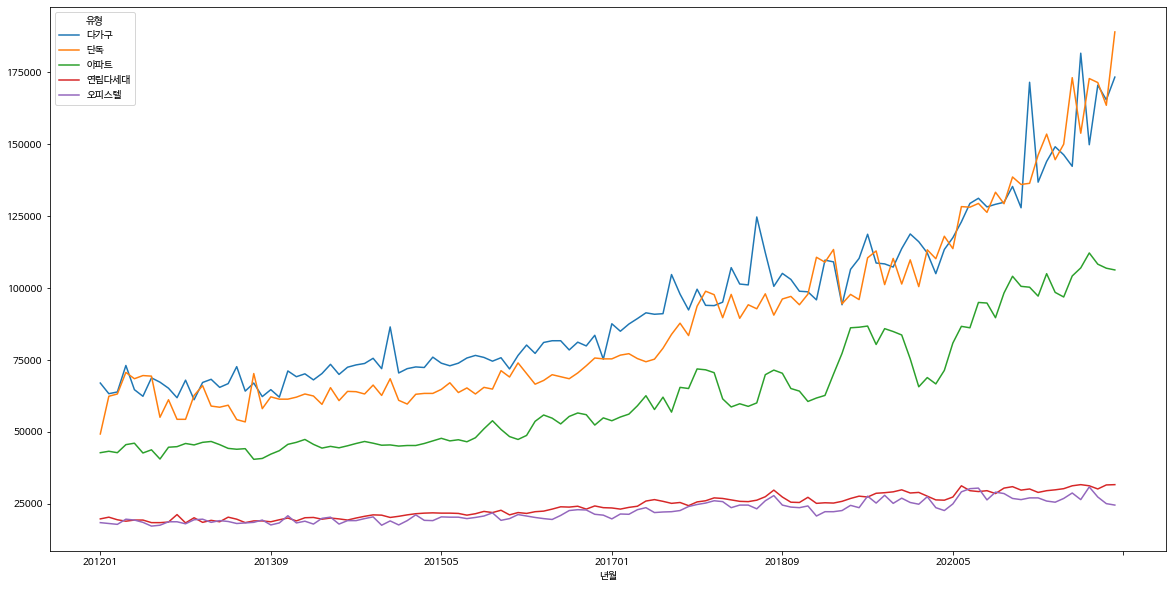

In [24]:
alt2_graph0.plot(figsize=(20,10))

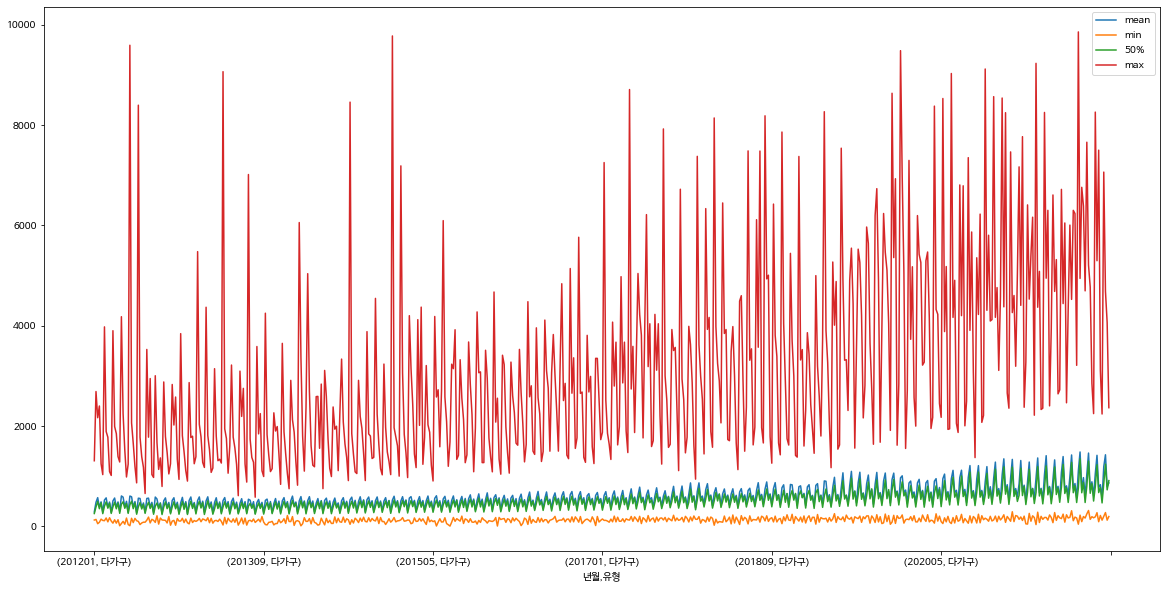

In [25]:
alt2_describe1.drop(['count','25%','75%','std'],axis=1).plot(figsize=(20,10))

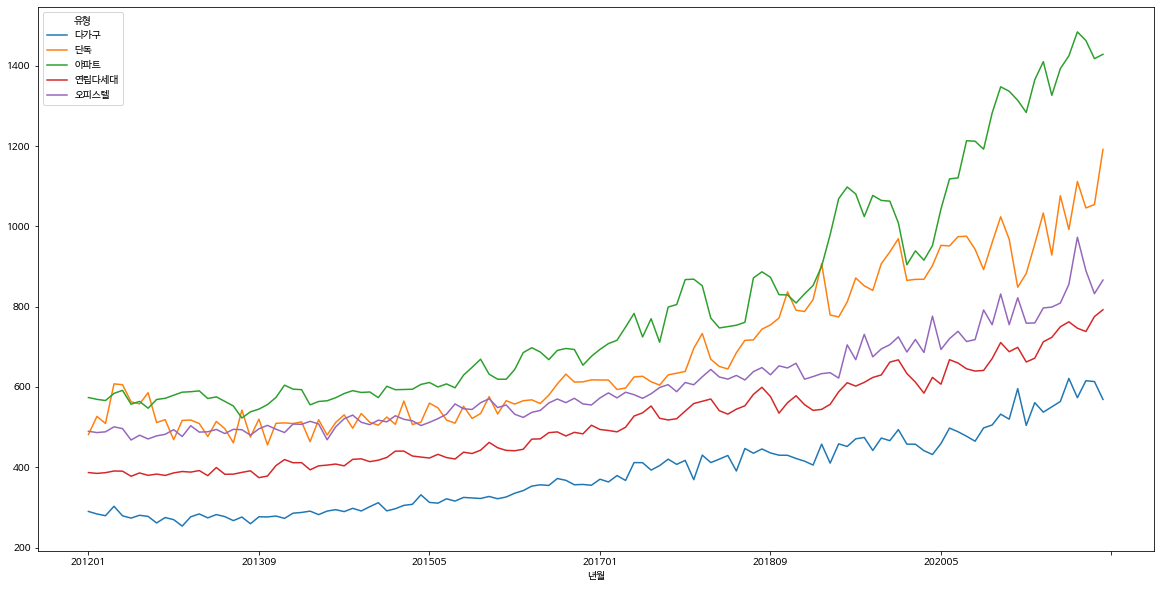

In [26]:
alt2_graph1.plot(figsize=(20,10))

###ML분석

In [27]:
df_alt2.head()

,년,월,일,시도명,시군구명,유형,면적,층,건축년도,거래금액,금액/면적,log,년월
0,2021,1,14,서울특별시,종로구,아파트,129.76,2,2000.0,130000,1001.85,6.909604,202101
1,2021,1,7,서울특별시,종로구,아파트,144.52,6,2008.0,150000,1037.92,6.944974,202101
2,2021,1,15,서울특별시,종로구,아파트,174.55,4,2004.0,175000,1002.58,6.910332,202101
3,2021,1,15,서울특별시,종로구,아파트,174.55,4,2004.0,175000,1002.58,6.910332,202101
4,2021,1,17,서울특별시,종로구,아파트,123.13,13,2004.0,180000,1461.87,7.287472,202101


In [28]:
df_alt2_ML=df_alt2.drop(['시도명','거래금액','금액/면적'],axis=1)
def year_divide4(x):
  if x in [1,2,3]:
    return 1
  elif x in [4,5,6]:
    return 2
  elif x in [7,8,9]:
    return 3
  elif x in [10,11,12]:
    return 4
df_alt2_ML['분기']=df_alt2_ML['월'].apply(year_divide4)
df_alt2_ML['년월']=df_alt2_ML['년월'].apply(int)
df_alt2_ML 

,년,월,일,시군구명,유형,면적,층,건축년도,log,년월,분기
0,2021,1,14,종로구,아파트,129.76,2,2000.0,6.909604,202101,1
1,2021,1,7,종로구,아파트,144.52,6,2008.0,6.944974,202101,1
2,2021,1,15,종로구,아파트,174.55,4,2004.0,6.910332,202101,1
3,2021,1,15,종로구,아파트,174.55,4,2004.0,6.910332,202101,1
4,2021,1,17,종로구,아파트,123.13,13,2004.0,7.287472,202101,1
...,...,...,...,...,...,...,...,...,...,...,...
1515808,2012,12,18,강동구,연립다세대,29.85,3,2011.0,6.326972,201212,4
1515809,2012,12,20,강동구,연립다세대,53.20,2,2010.0,6.132378,201212,4
1515810,2012,12,20,강동구,연립다세대,49.21,4,2012.0,6.285029,201212,4
1515811,2012,12,26,강동구,연립다세대,60.75,3,2002.0,5.903343,201212,4


In [29]:
df_alt2_ML.dtypes

년         int64
월         int64
일         int64
시군구명     object
유형       object
면적      float64
층         int64
건축년도    float64
log     float64
년월        int64
분기        int64
dtype: object

In [30]:
from sklearn.pipeline import make_pipeline
from sklearn.tree import export_graphviz 
from sklearn.tree import DecisionTreeRegressor
from category_encoders import OneHotEncoder

import graphviz

pipe=make_pipeline(
    
    OneHotEncoder(use_cat_names=True),
    DecisionTreeRegressor(random_state=1, criterion='mse')
)


In [31]:
X=df_alt2_ML.drop('log',axis=1)
Y=df_alt2_ML['log']

from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val=train_test_split(X,Y,random_state=1)

In [32]:
pipe.fit(X_train,y_train)
pipe.score(X_val,y_val)

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


0.7593012658103309

In [33]:
enc=pipe.named_steps['onehotencoder']
model_dt = pipe.named_steps['decisiontreeregressor']
encoded_col=enc.transform(X_val).columns
encoded_col

Index(['년', '월', '일', '시군구명_영등포구', '시군구명_노원구', '시군구명_동작구', '시군구명_마포구',
       '시군구명_동대문구', '시군구명_강남구', '시군구명_양천구', '시군구명_관악구', '시군구명_도봉구', '시군구명_강서구',
       '시군구명_서대문구', '시군구명_구로구', '시군구명_서초구', '시군구명_성북구', '시군구명_송파구', '시군구명_용산구',
       '시군구명_중랑구', '시군구명_강동구', '시군구명_강북구', '시군구명_은평구', '시군구명_중구', '시군구명_광진구',
       '시군구명_금천구', '시군구명_성동구', '시군구명_종로구', '유형_아파트', '유형_연립다세대', '유형_오피스텔',
       '유형_다가구', '유형_단독', '면적', '층', '건축년도', '년월', '분기'],
      dtype='object')

In [34]:
enc.transform(X_val)

,년,월,일,시군구명_영등포구,시군구명_노원구,시군구명_동작구,시군구명_마포구,시군구명_동대문구,시군구명_강남구,시군구명_양천구,...,유형_아파트,유형_연립다세대,유형_오피스텔,유형_다가구,유형_단독,면적,층,건축년도,년월,분기
616654,2017,2,21,0,0,1,0,0,0,0,...,0,1,0,0,0,56.30,-1,2003.0,201702,1
1035458,2015,3,2,0,0,0,0,0,0,0,...,0,1,0,0,0,66.69,4,2009.0,201503,1
865102,2016,6,4,0,1,0,0,0,0,0,...,1,0,0,0,0,41.30,15,1988.0,201606,2
1057255,2015,4,17,0,0,0,0,0,0,0,...,0,1,0,0,0,90.41,1,1995.0,201504,2
1498071,2012,10,8,0,0,0,0,0,0,0,...,0,1,0,0,0,55.85,3,2001.0,201210,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78479,2021,7,13,0,0,0,0,0,0,0,...,0,1,0,0,0,43.77,2,2015.0,202107,3
723895,2017,8,23,0,0,0,0,0,0,0,...,1,0,0,0,0,84.84,2,2009.0,201708,3
1112394,2015,7,17,0,0,0,0,0,0,0,...,1,0,0,0,0,84.98,9,2009.0,201507,3
1015771,2015,3,10,0,0,0,0,0,0,0,...,1,0,0,0,0,59.76,15,1996.0,201503,1


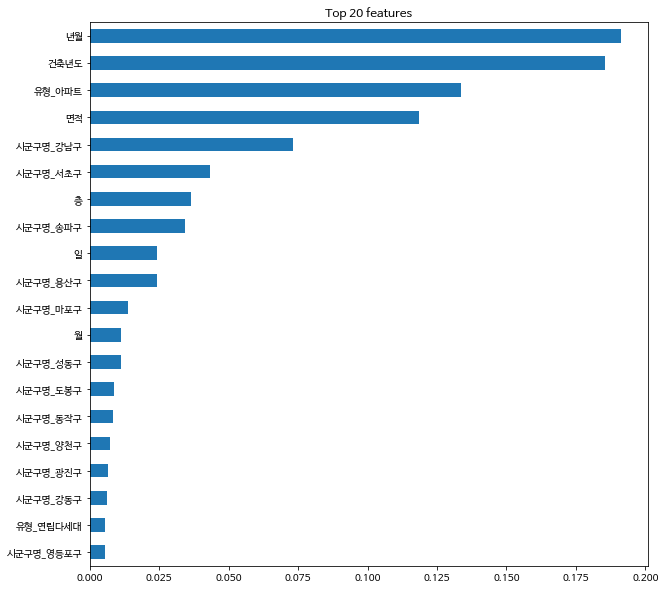

In [35]:
# 특성 중요도
rf = pipe.named_steps['decisiontreeregressor']
importances = pd.Series(rf.feature_importances_, encoded_col)


%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();


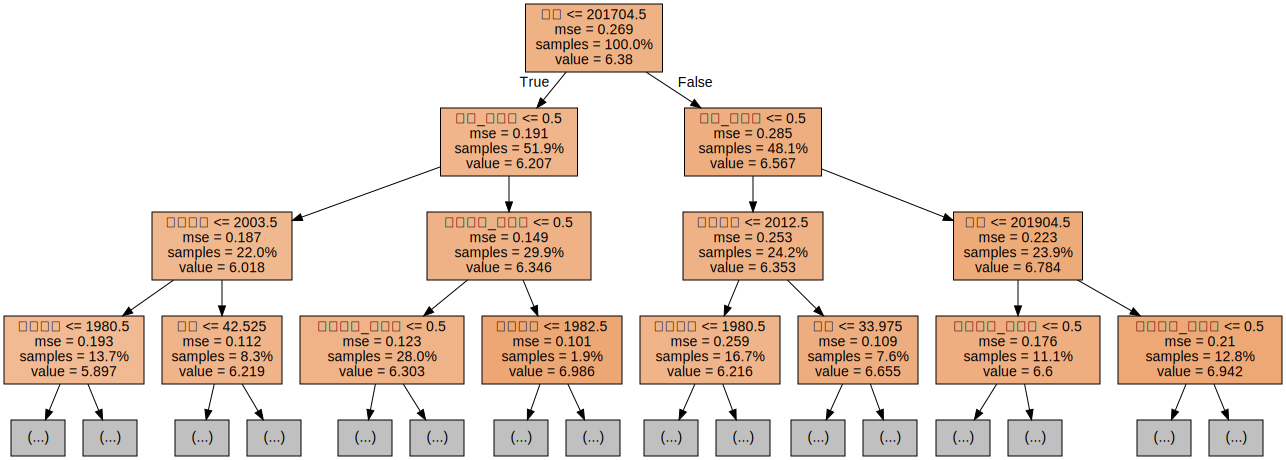

In [36]:
dot_data=export_graphviz(model_dt,max_depth=3,feature_names=encoded_col,class_names=['no','yes'],filled=True,proportion=True)

display(graphviz.Source(dot_data))

#####특정 요소 제거

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


0.5885986142139528


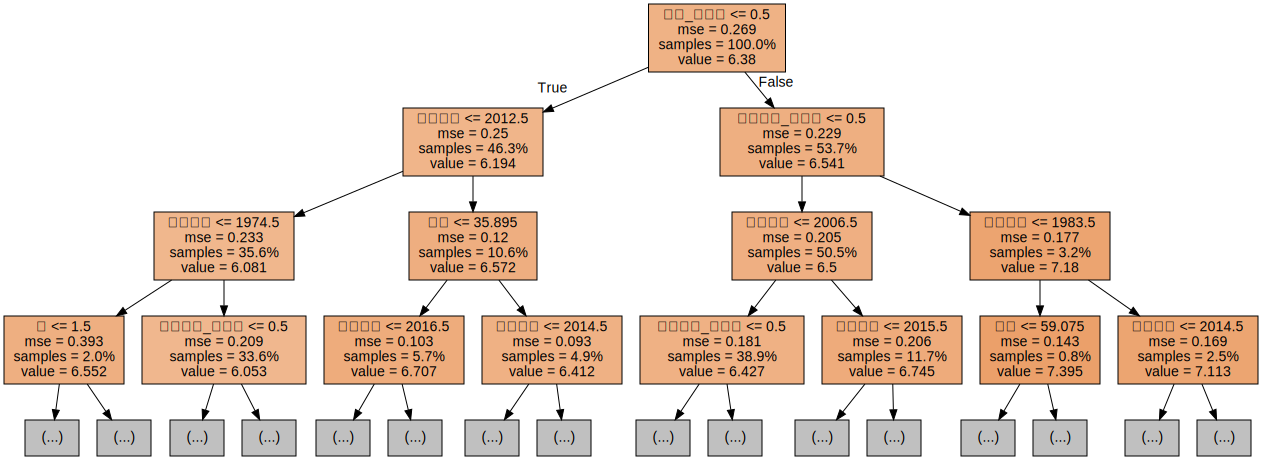

In [37]:
df_alt3=df_alt2_ML.drop(['년','월','일','년월','분기'],axis=1).copy()
X=df_alt3.drop('log',axis=1)
Y=df_alt3['log']

X_train,X_val,y_train,y_val=train_test_split(X,Y,random_state=1)
pipe2=make_pipeline(
    
    OneHotEncoder(use_cat_names=True),
    DecisionTreeRegressor(random_state=1, criterion='mse')
)
pipe2.fit(X_train,y_train)
print(pipe2.score(X_val,y_val))
enc=pipe2.named_steps['onehotencoder']
model_dt = pipe2.named_steps['decisiontreeregressor']
encoded_col=enc.transform(X_val).columns
dot_data=export_graphviz(model_dt,max_depth=3,feature_names=encoded_col,class_names=['no','yes'],filled=True,proportion=True)

display(graphviz.Source(dot_data))

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


0.13486956261782101


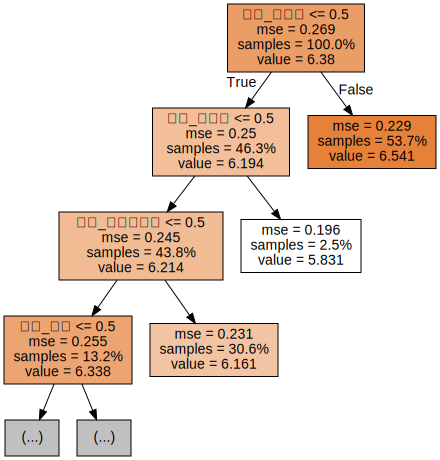

In [38]:
X=df_alt3['유형']
Y=df_alt3['log']

X_train,X_val,y_train,y_val=train_test_split(X,Y,random_state=1)
pipe3=make_pipeline(
    
    OneHotEncoder(use_cat_names=True),
    DecisionTreeRegressor(random_state=1, criterion='mse')
)
pipe3.fit(X_train,y_train)
print(pipe3.score(X_val,y_val))
enc=pipe3.named_steps['onehotencoder']
model_dt = pipe3.named_steps['decisiontreeregressor']
encoded_col=enc.transform(X_val).columns
dot_data=export_graphviz(model_dt,max_depth=3,feature_names=encoded_col,class_names=['no','yes'],filled=True,proportion=True)

display(graphviz.Source(dot_data))

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


0.26123917472187996


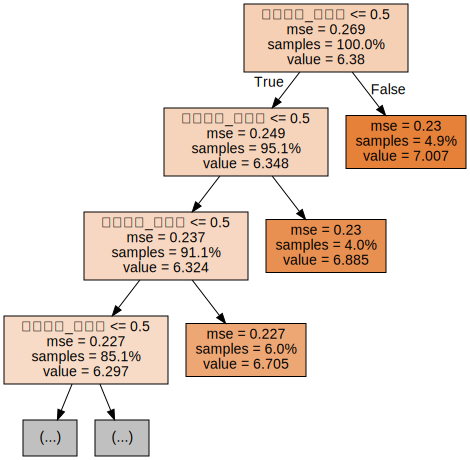

In [39]:
X=df_alt3['시군구명']
Y=df_alt3['log']

X_train,X_val,y_train,y_val=train_test_split(X,Y,random_state=1)
pipe4=make_pipeline(
    
    OneHotEncoder(use_cat_names=True),
    DecisionTreeRegressor(random_state=1, criterion='mse')
)
pipe4.fit(X_train,y_train)
print(pipe4.score(X_val,y_val))
enc=pipe4.named_steps['onehotencoder']
model_dt = pipe4.named_steps['decisiontreeregressor']
encoded_col=enc.transform(X_val).columns
dot_data=export_graphviz(model_dt,max_depth=3,feature_names=encoded_col,class_names=['no','yes'],filled=True,proportion=True)

display(graphviz.Source(dot_data))